In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
# import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = False

In [88]:
if kharpov:
    true_params = {'theta': 0.50, 
               'pi': -7,
               'phi': -.1,
               'scale': .1,
               'delta': 1.11,
               'rho': .4,
              }
else:
     true_params = {'theta': 0.53, 
               'pi': -.2,
               'phi': -.35,
               'scale': 3.12,
               'delta': 0.27,
               'rho': .81,
              }
    
time_dim = 3700
sim_dim = 1000
innov_dim = 10

In [89]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [90]:
total_true_params

{'theta': 0.53,
 'pi': -0.2,
 'phi': -0.35,
 'scale': 3.12,
 'delta': 0.27,
 'rho': 0.81,
 'gamma': 0.18314971022681162,
 'beta': 0.2700839339013833,
 'psi': -0.17360760599671177,
 'zeta': 0.8775000000000001}

## Setup the linking functions.

In [92]:
true_params['phi']

-0.35

In [93]:
vl.estimate_params(data)

({'gamma': 0.19767390865735218,
  'beta': 0.36936669252519144,
  'psi': -0.14401293273857155,
  'zeta': 0.8938768864550047,
  'delta': 0.2835224495604355,
  'rho': 0.826472728715555,
  'scale': 2.9078038292724524},
                beta     delta         gamma           psi       rho     scale  \
 beta   6.945789e-12  0.000000 -1.195175e-13 -6.921676e-12  0.000000  0.000000   
 delta  0.000000e+00  0.000286  0.000000e+00  0.000000e+00 -0.000128 -0.000359   
 gamma -1.195175e-13  0.000000  2.014461e-13  7.845978e-14  0.000000  0.000000   
 psi   -6.921676e-12  0.000000  7.845978e-14  4.929776e-05  0.000000  0.000000   
 rho    0.000000e+00 -0.000128  0.000000e+00  0.000000e+00  0.000336 -0.000324   
 scale  0.000000e+00 -0.000359  0.000000e+00  0.000000e+00 -0.000324  0.015548   
 zeta   0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000   
 
            zeta  
 beta   0.000000  
 delta  0.000000  
 gamma  0.000000  
 psi    0.000000  
 rho    0.000000  
 scale  0.000

## We start by examining the distributions of simulated data

In [94]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

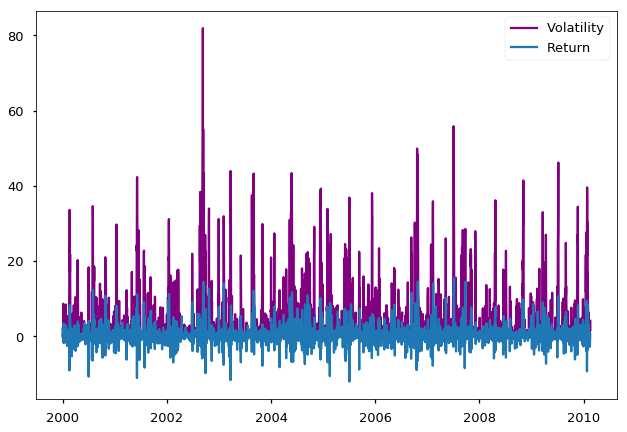

In [98]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.vol, label='Volatility', color='purple')
ax1.plot(data.rtn, label='Return')
ax1.legend()

In [96]:
data.cov()

,vol,rtn
vol,50.566814,1.641885
rtn,1.641885,5.336680


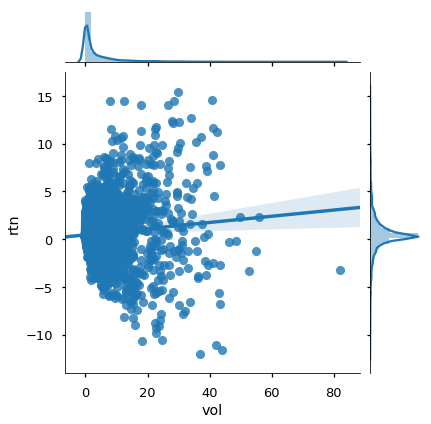

In [99]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [100]:
data.describe()

,vol,rtn
count,3.700000e+03,3700.000000
mean,4.034103e+00,0.572719
std,7.111035e+00,2.310126
min,1.805289e-15,-12.003410
25%,6.931294e-02,-0.147525
50%,9.565219e-01,0.318927
75%,4.859271e+00,1.155975
max,8.191812e+01,15.436459


## I now estimate all of the parameters

In [101]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [102]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [103]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [104]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean   / np.sqrt(np.diag(cov) / data.vol.size)

In [105]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

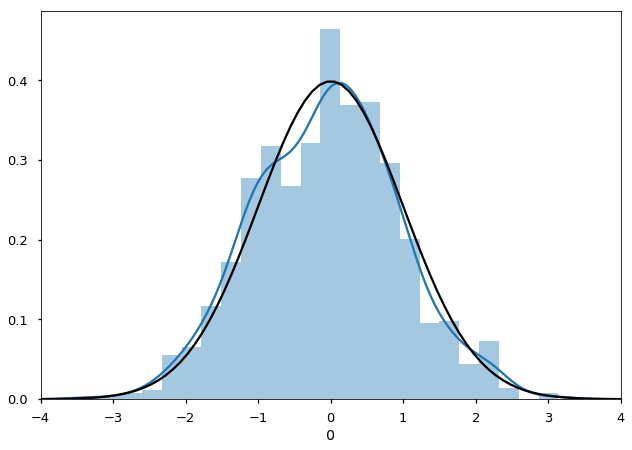

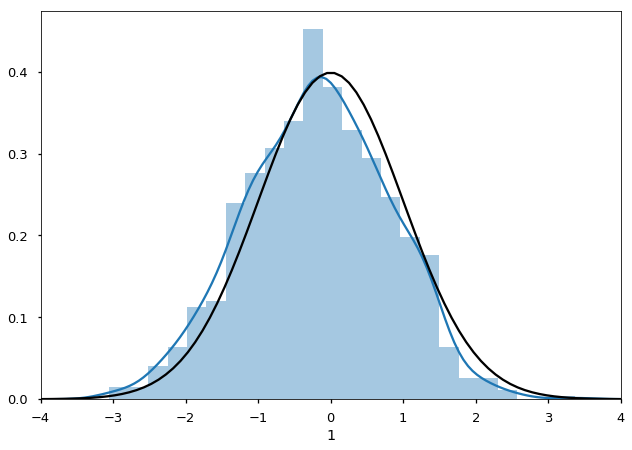

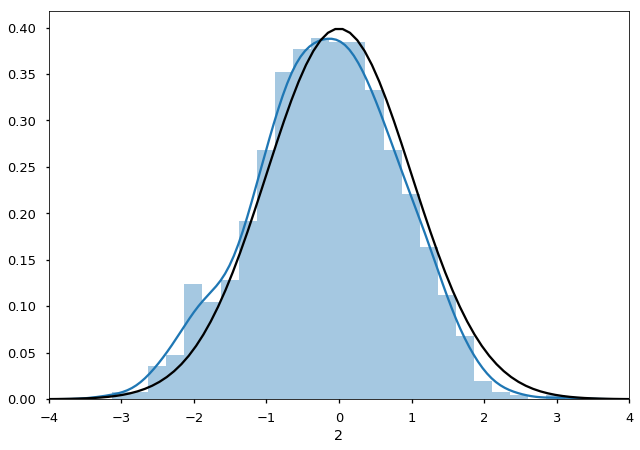

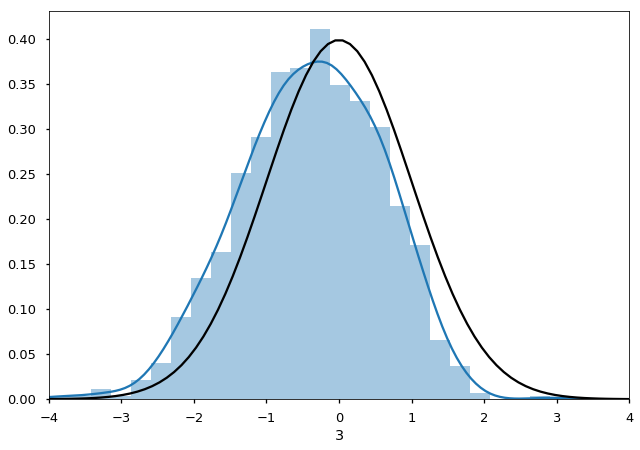

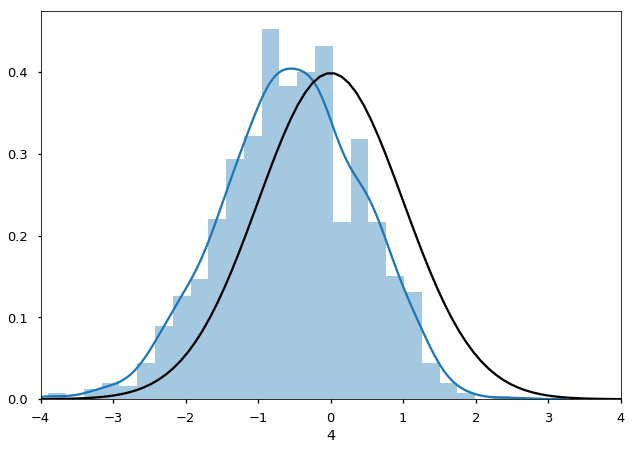

In [106]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

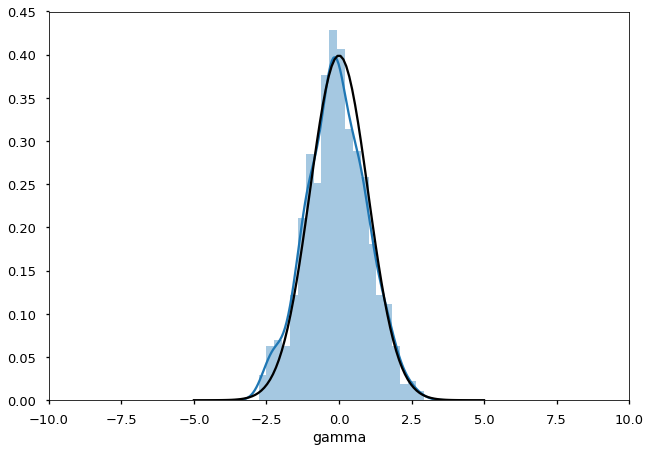

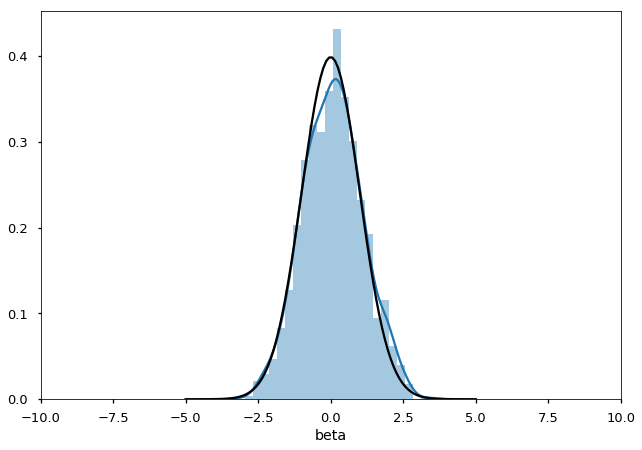

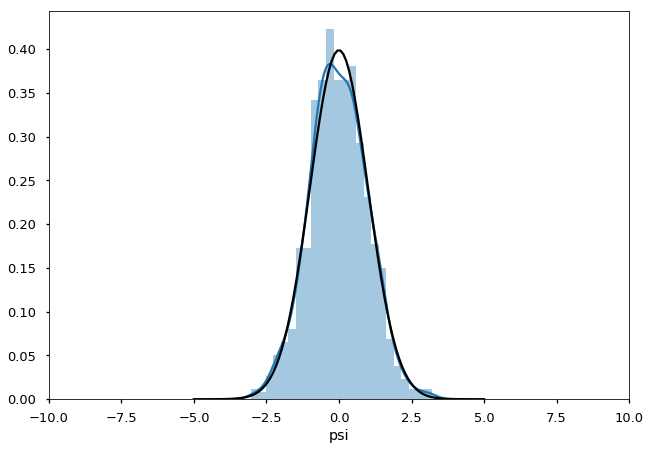

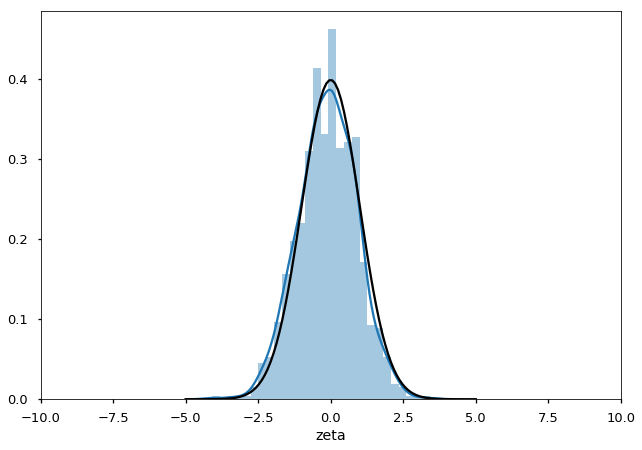

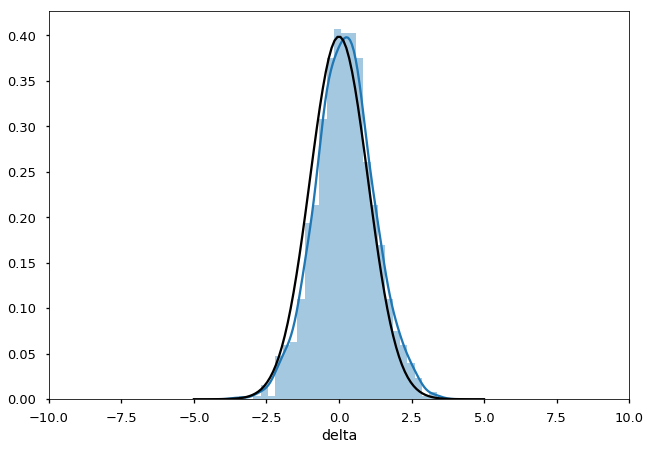

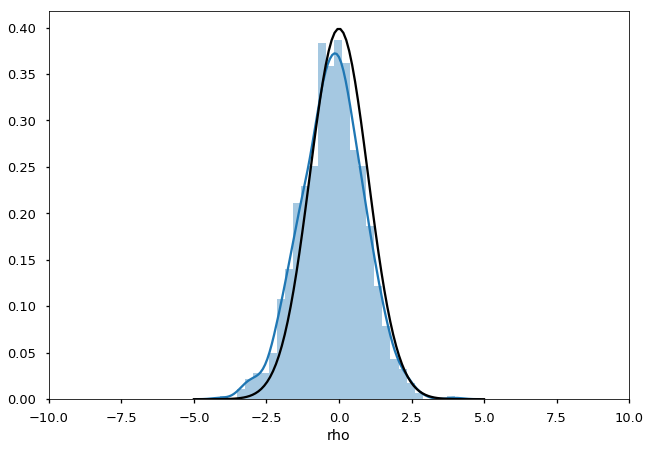

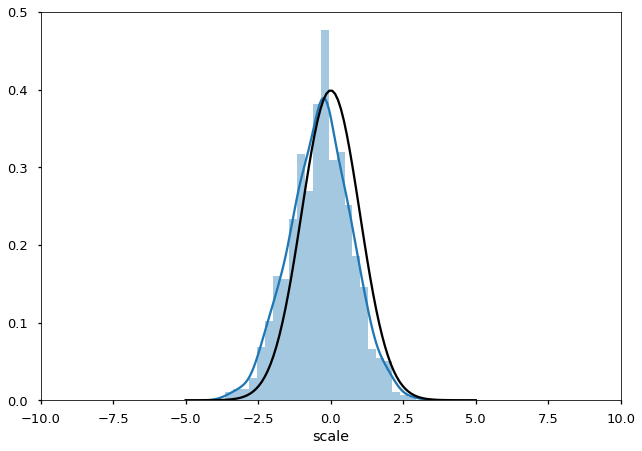

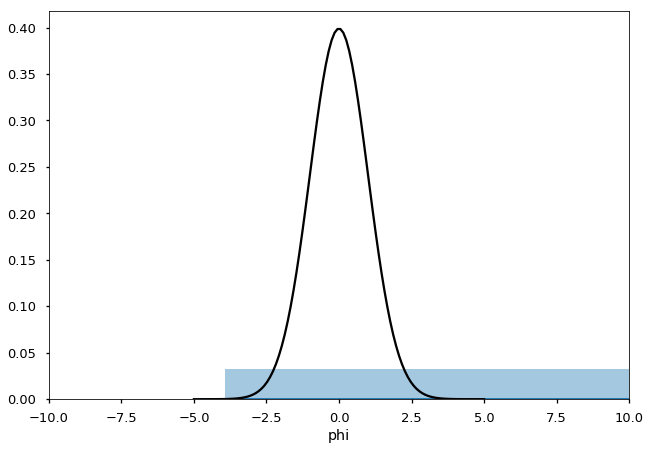

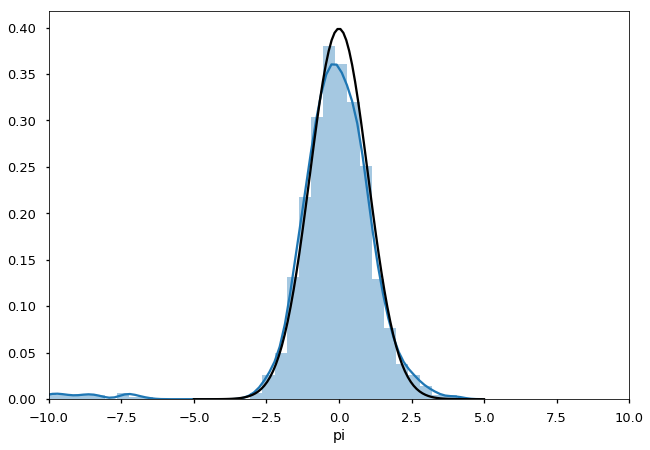

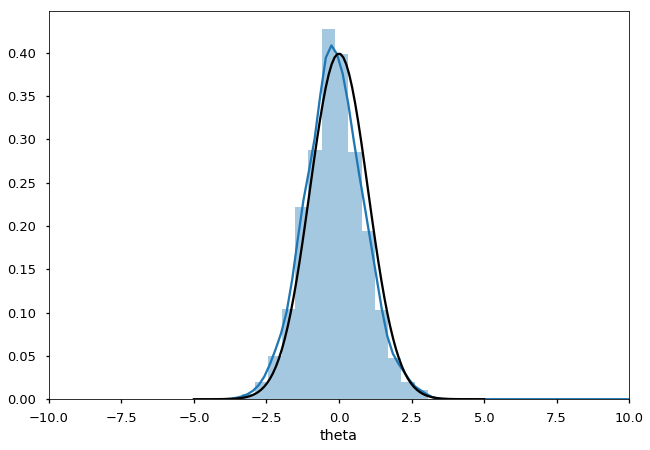

In [107]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if name != 'phi'
            ax.set_xlim([-10,10])

# I now compute the robust conditional QLR statistic 

In [108]:
true_params

{'theta': 0.53,
 'pi': -0.2,
 'phi': -0.35,
 'scale': 3.12,
 'delta': 0.27,
 'rho': 0.81}

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=200, alpha=0.05,
                                        robust_quantile=True)

In [115]:
returnval.mean()

qlr_stat                4.027045
robust_qlr_qauntile    43.198260
robust                  0.000000
standard                0.123000
dtype: float64

In [116]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
else:
    filename = '../results/reject_prop_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
    
returnval.to_json(filename)

In [117]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,6.308770,27.219601,False,False
1,4.648906,24.372435,False,False
2,8.164010,31.299372,False,True
3,22.883786,37.058172,False,True
4,2.526651,21.960131,False,False


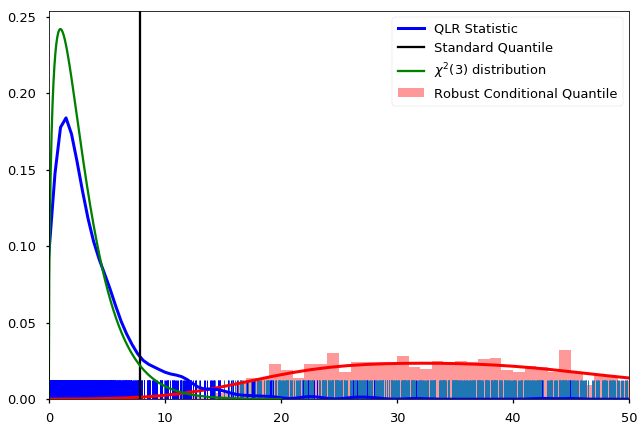

In [122]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.robust_qlr_qauntile, rug=True, kde_kws={"color": "red", "lw": 3},
                 hist_kws={"color":'red'}, ax=ax4, bins=np.arange(0, min(returnval.robust_qlr_qauntile.max(), 5000),1),
                label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, rug=True, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3},
            rug_kws={'color':'blue'}, label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
# xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.pdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)